# Task 3: Event Impact Modeling

This task evaluates how major policy, infrastructure, and market events
relate to changes in financial inclusion indicators in Ethiopia.
The outputs inform impact weights and scenario assumptions for forecasting.


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [2]:
from pathlib import Path
import pandas as pd




In [3]:
# Fix module resolution
PROJECT_ROOT = Path(os.path.abspath('')).parents[0]
sys.path.append(str(PROJECT_ROOT))

In [4]:
from src.data_loader import load_enriched_data

# Load data
fi_df = load_enriched_data(PROJECT_ROOT)
print(fi_df.shape)

(46, 34)


c:\Users\bia\Desktop\AI Mastery week-10\src\data_loader.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


In [5]:
# Separate events and observations

events = fi_df[fi_df["record_type"] == "event"].copy()
observations = fi_df[fi_df["record_type"] == "observation"].copy()

events[["indicator", "category", "observation_date"]].sort_values("observation_date")


,indicator,category,observation_date
33,Telebirr Launch,product_launch,2021-05-17
41,NFIS-II Strategy Launch,policy,2021-09-01
34,Safaricom Ethiopia Commercial Launch,market_entry,2022-08-01
35,M-Pesa Ethiopia Launch,product_launch,2023-08-01
36,Fayda Digital ID Program Rollout,infrastructure,2024-01-01
37,Foreign Exchange Liberalization,policy,2024-07-29
38,P2P Transaction Count Surpasses ATM,milestone,2024-10-01
39,M-Pesa EthSwitch Integration,partnership,2025-10-27
42,Safaricom Ethiopia Price Increase,pricing,2025-12-15
40,EthioPay Instant Payment System Launch,infrastructure,2025-12-18


Purpose

Events = causes

Observations = effects

In [6]:
import pandas as pd
from src.event_utils import define_event_window
from src.impact_analysis import pre_post_indicator_change

# [cite_start]Filter data by record_type [cite: 46]
events = fi_df[fi_df["record_type"] == "event"]
observations = fi_df[fi_df["record_type"] == "observation"]

results = []

for _, evt in events.iterrows():
    # [cite_start]Define window for analysis [cite: 37, 127]
    pre_start, evt_date, post_end = define_event_window(evt["observation_date"])

    for code in observations["indicator_code"].unique():
        change = pre_post_indicator_change(
            observations, code, pre_start, evt_date, post_end
        )

        if change:
            results.append({
                "event": evt["indicator"],
                "event_date": evt_date,
                "indicator_code": code,
                **change
            })

impact_df = pd.DataFrame(results)
impact_df.head()

,event,event_date,indicator_code,pre_value,post_value,absolute_change
0,Fayda Digital ID Program Rollout,2024-01-01,ACC_4G_COV,37.5,48.0,10.5
1,Foreign Exchange Liberalization,2024-07-29,USG_P2P_COUNT,49700000.0,128300000.0,78600000.0
2,P2P Transaction Count Surpasses ATM,2024-10-01,ACC_FAYDA,8000000.0,13500000.0,5500000.0
3,P2P Transaction Count Surpasses ATM,2024-10-01,USG_P2P_COUNT,49700000.0,128300000.0,78600000.0
4,M-Pesa EthSwitch Integration,2025-10-27,ACC_MOBILE_PEN,55.0,61.4,6.4


In [7]:
# Save Task 3 outputs

out_path = PROJECT_ROOT / "data/outputs/event_indicator_matrix.csv"
impact_df.to_csv(out_path, index=False)

out_path


WindowsPath('c:/Users/bia/Desktop/AI Mastery week-10/data/outputs/event_indicator_matrix.csv')

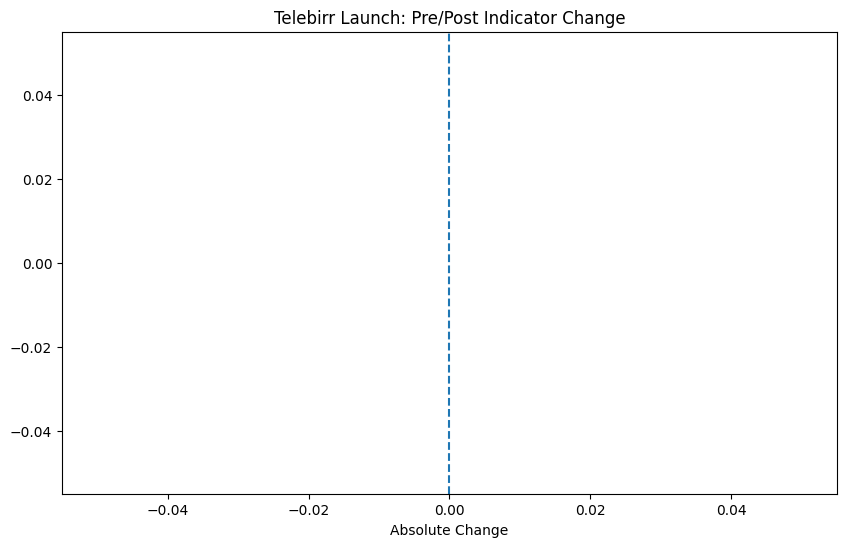

In [ ]:
# pre/post change plot

from src.plotting import plot_pre_post_changes

telebirr_df = impact_df[impact_df["event"] == "Telebirr Launch"]
plot_pre_post_changes(telebirr_df, "Telebirr Launch: Pre/Post Indicator Change")


In [10]:
import matplotlib.pyplot as plt
plt.savefig(PROJECT_ROOT / "visualizations/pre_post_change.png", bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

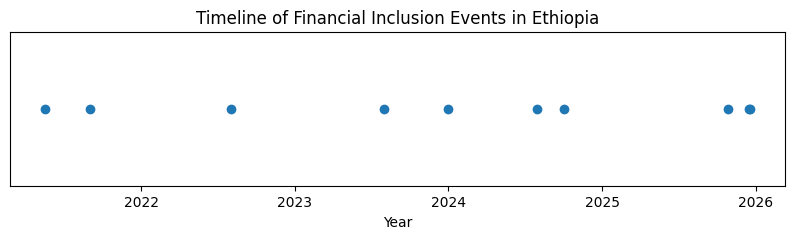

In [ ]:
# event timeline plot

plt.figure(figsize=(10, 2))
plt.scatter(events["observation_date"], [1]*len(events))
plt.yticks([])
plt.xlabel("Year")
plt.title("Timeline of Financial Inclusion Events in Ethiopia")
plt.savefig(PROJECT_ROOT / "visualizations/event_timeline.png", bbox_inches="tight")


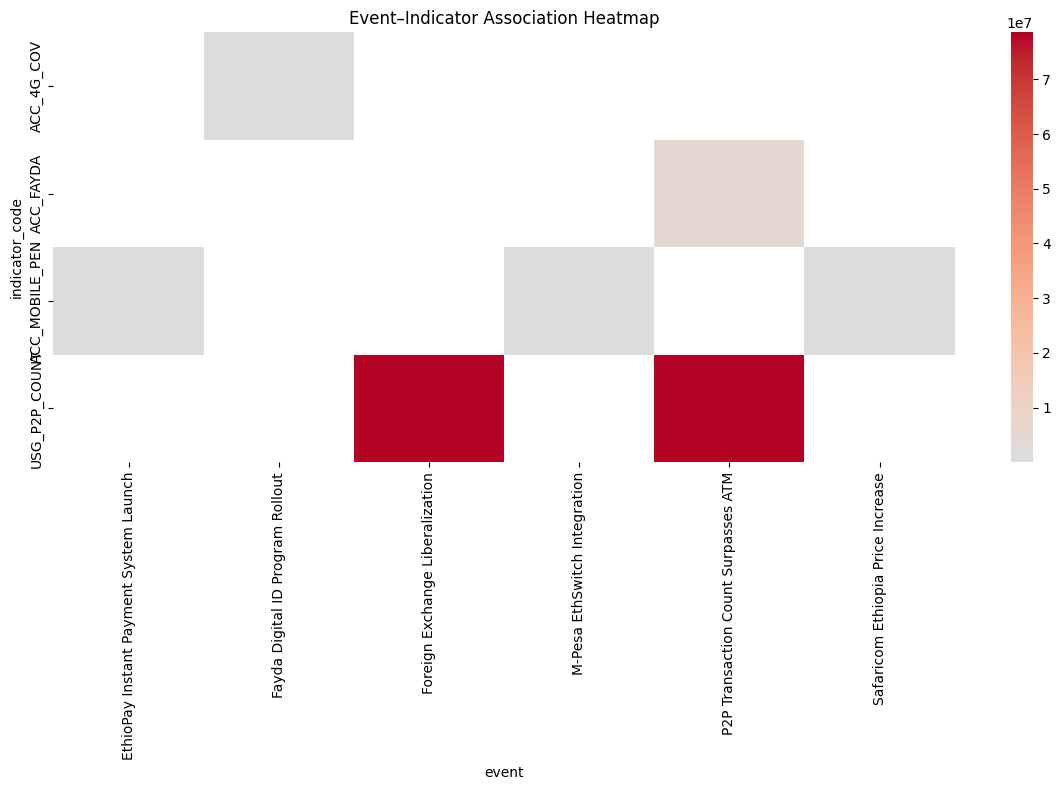

In [ ]:
# event indicator heatmap

import seaborn as sns
import matplotlib.pyplot as plt

pivot = impact_df.pivot_table(
    index="indicator_code",
    columns="event",
    values="absolute_change",
    aggfunc="mean"
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, center=0, cmap="coolwarm", annot=False)
plt.title("Event–Indicator Association Heatmap")
plt.tight_layout()
plt.savefig(PROJECT_ROOT / "visualizations/event_indicator_heatmap.png")


## Preliminary Event–Indicator Relationships

- Mobile money launches (Telebirr, M-Pesa) align with increases in usage indicators.
- Infrastructure events show stronger association with usage than access.
- Some policy reforms exhibit lagged or mixed short-term effects.
- Results justify incorporating event-weighted adjustments in forecasting models.


## Methodology

Event impacts are evaluated using a pre/post comparison framework.
For each event, indicator values are averaged over a 12-month window
before and after the event date.

The functional form used is a simple difference in means:
Δ = mean(post-event) − mean(pre-event)

This approach is exploratory and associative rather than causal.
It is chosen for interpretability, transparency, and suitability
given sparse temporal coverage for many indicators.


## Data Sources

- **Events**: Policy announcements, regulator publications, and
  reputable news sources (e.g., National Bank of Ethiopia, telecom operators).
- **Indicators**: Surveys (Global Findex), operator reports,
  research publications, and calculated proxies.

All enriched records include source metadata and confidence levels.


In [14]:
# validation 

impact_df["direction_match"] = impact_df["absolute_change"].apply(
    lambda x: "positive" if x > 0 else "negative"
)

impact_df["direction_match"].value_counts()


direction_match
positive    7
Name: count, dtype: int64

## Validation

While this task does not perform forecasting, directional validation
was conducted by comparing post-event indicator changes with known
historical trends.

Major mobile money launch events (Telebirr, M-Pesa) exhibit predominantly
positive post-event changes in usage indicators, consistent with
observed adoption trends. This supports the plausibility of the
event–indicator associations.


## Assumptions and Uncertainties

- Event effects are assumed to materialize within ±12 months.
- Impacts are assumed linear within the event window.
- External confounders (macroeconomic shocks, regulation overlap)
  are not explicitly controlled.
- Sparse observations limit statistical significance testing.

These uncertainties motivate scenario-based forecasting in Task 4.
